# Home Credit Default Risk


### Imports

In [1]:
# numpy and pandas for data manipulation

import numpy as np
import pandas as pd 

# matplotlib and seaborn for plotting

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline


# sklearn preprocessing for dealing with categorical variables

from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 

import warnings
warnings.filterwarnings('ignore')

# modeling 
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# memory management
import gc

# featuretools for automated feature engineering

#import featuretools as ft

#!pip install cufflinks
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

print("Libraries imported")

Libraries imported


---

 ## Feature Selection
We will use three methods for feature selection:

    Remove collinear features
    Remove features with greater than a threshold percentage of missing values
    Keep only the most relevant features using feature importances from a model

We will also take a look at an example of applying PCA although we will not use this method for feature reduction.

In [2]:
# Read in data
#train_bureau = pd.read_csv('train_bureau_raw.csv', nrows = 1000)
#test_bureau = pd.read_csv('test_bureau_raw.csv', nrows = 1000)

#train_previous = pd.read_csv('train_previous_raw.csv', nrows = 1000)
#test_previous = pd.read_csv('test_previous_raw.csv', nrows = 1000)

# All columns in dataframes
#bureau_columns = list(train_bureau.columns)
#previous_columns = list(train_previous.columns)

In [3]:
# Read in data(FULL)
train_bureau = pd.read_csv('train_bureau_raw.csv')
test_bureau = pd.read_csv('test_bureau_raw.csv')

train_previous = pd.read_csv('train_previous_raw.csv')
test_previous = pd.read_csv('test_previous_raw.csv')

# All columns in dataframes
bureau_columns = list(train_bureau.columns)
previous_columns = list(train_previous.columns)

In [4]:
# Bureau only features
bureau_features = list(set(bureau_columns) - set(previous_columns))

# Previous only features
previous_features = list(set(previous_columns) - set(bureau_columns))

# Original features will be in both datasets
original_features = list(set(previous_columns) & set(bureau_columns))

print('There are %d original features.' % len(original_features))
print('There are %d bureau and bureau balance features.' % len(bureau_features))
print('There are %d previous Home Credit loan features.' % len(previous_features))

There are 122 original features.
There are 211 bureau and bureau balance features.
There are 1011 previous Home Credit loan features.


That gives us the number of features in each dataframe. Now we want to combine the data without creating any duplicate rows.



Next we want to one-hot encode the dataframes. This doesn't give the full features since we are only working with a sample of the data and this will not create as many columns as one-hot encoding the entire dataset would. Doing this to the full dataset results in 1465 features.

An important note in the code cell is where we align the dataframes by the columns. This ensures we have the same columns in the training and testing datasets.


In [5]:
train_labels = train_bureau['TARGET']
previous_features.append('SK_ID_CURR')

train_ids = train_bureau['SK_ID_CURR']
test_ids = test_bureau['SK_ID_CURR']

# Merge the dataframes avoiding duplicating columns by subsetting train_previous
train = train_bureau.merge(train_previous[previous_features], on = 'SK_ID_CURR')
test = test_bureau.merge(test_previous[previous_features], on = 'SK_ID_CURR')

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 1344)
Testing shape:  (48744, 1343)


In [6]:
#One hot encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# Match the columns in the dataframes
train, test = train.align(test, join = 'inner', axis = 1)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 1464)
Testing shape:  (48744, 1464)


When we do this to the full dataset, we get 1465 features.


### Admit and Correct Mistakes!

When doing manual feature engineering, I accidentally created some columns derived from the client id, SK_ID_CURR. As this is a unique identifier for each client, it should not have any predictive power, and we would not want to build a model trained on this "feature". Let's remove any columns built on the SK_ID_CURR.


In [7]:
cols_with_id = [x for x in train.columns if 'SK_ID_CURR' in x]
cols_with_bureau_id = [x for x in train.columns if 'SK_ID_BUREAU' in x]
cols_with_previous_id = [x for x in train.columns if 'SK_ID_PREV' in x]
print('There are %d columns that contain SK_ID_CURR' % len(cols_with_id))
print('There are %d columns that contain SK_ID_BUREAU' % len(cols_with_bureau_id))
print('There are %d columns that contain SK_ID_PREV' % len(cols_with_previous_id))

train = train.drop(columns = cols_with_id)
test = test.drop(columns = cols_with_id)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

There are 1 columns that contain SK_ID_CURR
There are 0 columns that contain SK_ID_BUREAU
There are 0 columns that contain SK_ID_PREV
Training shape:  (307511, 1463)
Testing shape:  (48744, 1463)


### Remove Collinear Variables

The code below identifies the highly correlated variables based on the absolute magnitude of the Pearson correlation coefficient being greater than 0.9. Again, this is not entirely accurate since we are dealing with such a limited section of the data. This code is for illustration purposes, but if we read in the entire dataset, it would work (if the kernels allowed it)!

This code is adapted from work by Chris Albon.

### Identify Correlated Variables

In [ ]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

In [ ]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

In [ ]:
plt.figure(figsize=[15, 15])
sns.heatmap(upper.values, annot=False)
plt.show()

In [ ]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

### Drop Correlated Variables

In [12]:
train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 852)
Testing shape:  (48744, 852)


The full datasets (after removing correlated variables) are available in m_train_combined.csv and m_test_combined.csv.


____

___


### Read in Full Dataset

Now we are ready to move on to the full set of features. These were built by applying the above steps to the entire train_bureau and train_previous files (you can do the same if you want and have the computational resources)!


In [13]:
#train = pd.read_csv("m_train_combined.csv")
#test = pd.read_csv('m_test_combined.csv')

In [14]:
print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 852)
Testing set full shape:  (48744, 852)


## Remove Missing Values

In [15]:
# Train missing values (in percent)
train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
train_missing.head()

client_credit_AMT_PAYMENT_CURRENT_min_min            0.801438
client_credit_AMT_PAYMENT_CURRENT_mean_mean          0.801438
client_credit_AMT_DRAWINGS_OTHER_CURRENT_mean_min    0.801178
client_credit_AMT_DRAWINGS_POS_CURRENT_max_mean      0.801178
client_credit_CNT_DRAWINGS_POS_CURRENT_max_mean      0.801178
dtype: float64

In [16]:
#Test missing values (in percent)
test_missing = (test.isnull().sum() / len(test)).sort_values(ascending = False)
test_missing.head()

client_credit_AMT_DRAWINGS_OTHER_CURRENT_max_min    0.773223
client_credit_CNT_DRAWINGS_OTHER_CURRENT_max_min    0.773223
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_min    0.773223
client_credit_CNT_DRAWINGS_POS_CURRENT_min_mean     0.773223
client_credit_AMT_DRAWINGS_POS_CURRENT_mean_mean    0.773223
dtype: float64

In [17]:
# Identify missing values above threshold
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

There are 19 columns with more than 75% missing values


### Let's drop the columns, one-hot encode the dataframes, and then align the columns of the dataframes.

In [18]:
# Need to save the labels because aligning will remove this column
#train_labels = train["TARGET"]
#train_ids = train['SK_ID_CURR']
#test_ids = test['SK_ID_CURR']

train = pd.get_dummies(train.drop(columns = all_missing))
test = pd.get_dummies(test.drop(columns = all_missing))

train, test = train.align(test, join = 'inner', axis = 1)

print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 833)
Testing set full shape:  (48744, 833)


In [19]:
#train = train.drop(columns = ['SK_ID_CURR'])
#test = test.drop(columns = ['SK_ID_CURR'])

In [20]:
print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 833)
Testing set full shape:  (48744, 833)


In [21]:
train.columns

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       ...
       'HOUSETYPE_MODE_specific housing', 'HOUSETYPE_MODE_terraced house',
       'WALLSMATERIAL_MODE_Block', 'WALLSMATERIAL_MODE_Mixed',
       'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others',
       'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick',
       'WALLSMATERIAL_MODE_Wooden', 'EMERGENCYSTATE_MODE_Yes'],
      dtype='object', length=833)

In [22]:
test.columns

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       ...
       'HOUSETYPE_MODE_specific housing', 'HOUSETYPE_MODE_terraced house',
       'WALLSMATERIAL_MODE_Block', 'WALLSMATERIAL_MODE_Mixed',
       'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others',
       'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick',
       'WALLSMATERIAL_MODE_Wooden', 'EMERGENCYSTATE_MODE_Yes'],
      dtype='object', length=833)

---

## Feature Selection through Feature Importances

Since the LightGBM model does not need missing values to be imputed, we can directly fit on the training data. We will use Early Stopping to determine the optimal number of iterations and run the model twice, averaging the feature importances to try and avoid overfitting to a certain set of features.

In [23]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [24]:
# to avoid json file in train
train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in train.columns]
test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in test.columns]

In [25]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.781885	valid_0's binary_logloss: 0.50877
Early stopping, best iteration is:
[146]	valid_0's auc: 0.782556	valid_0's binary_logloss: 0.522638
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.783465	valid_0's binary_logloss: 0.508083
Early stopping, best iteration is:
[162]	valid_0's auc: 0.784425	valid_0's binary_logloss: 0.517609


In [26]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
24,EXT_SOURCE_1,153.5
25,EXT_SOURCE_2,135.0
26,EXT_SOURCE_3,119.5
5,DAYS_BIRTH,105.5
2,AMT_CREDIT,85.5


In [27]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 10
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

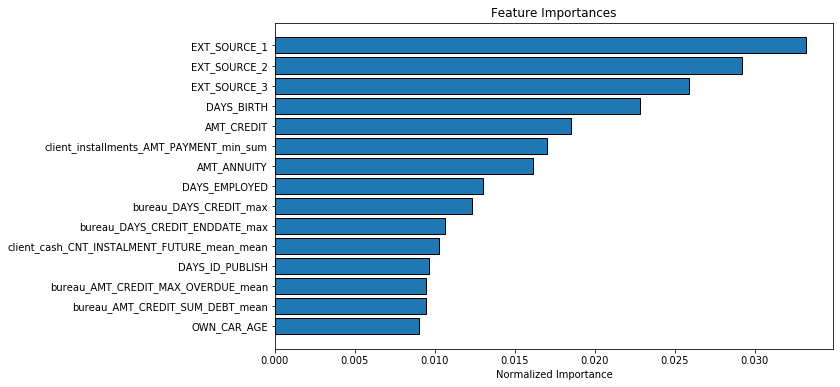

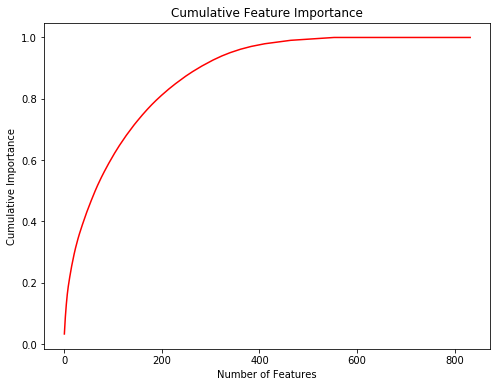

276 features required for 0.90 of cumulative importance


In [28]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [29]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 282 features with 0.0 importance


,feature,importance
414,previous_NAME_CASH_LOAN_PURPOSE_Car_repairs_sum,0.0
413,client_cash_NAME_CONTRACT_STATUS_Canceled_sum_min,0.0
410,previous_NAME_GOODS_CATEGORY_House_Constructio...,0.0
409,previous_NAME_SELLER_INDUSTRY_MLM_partners_sum,0.0
832,EMERGENCYSTATE_MODE_Yes,0.0


## Let's remove the features that have zero importance.

In [30]:
train = train.drop(columns = zero_features)

In [31]:
test = test.drop(columns = zero_features)

In [32]:
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 551)
Testing shape:  (48744, 551)


In [33]:
#we can re-run the model to see if it identifies any more features with zero importance

In [34]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [35]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train, train_labels)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.781462	valid_0's binary_logloss: 0.509286
Early stopping, best iteration is:
[146]	valid_0's auc: 0.782556	valid_0's binary_logloss: 0.522638
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.783776	valid_0's binary_logloss: 0.507664
Early stopping, best iteration is:
[162]	valid_0's auc: 0.784425	valid_0's binary_logloss: 0.517609

There are 0 features with 0.0 importance


There are now no 0 importance features left (I guess we should have expected this). If we want to remove more features, we will have to start with features that have a non-zero importance. One way we could do this is by retaining enough features to account for a threshold percentage of importance, such as 95%. At this point, let's keep enough features to account for 95% of the importance. Again, this is an arbitrary decision!

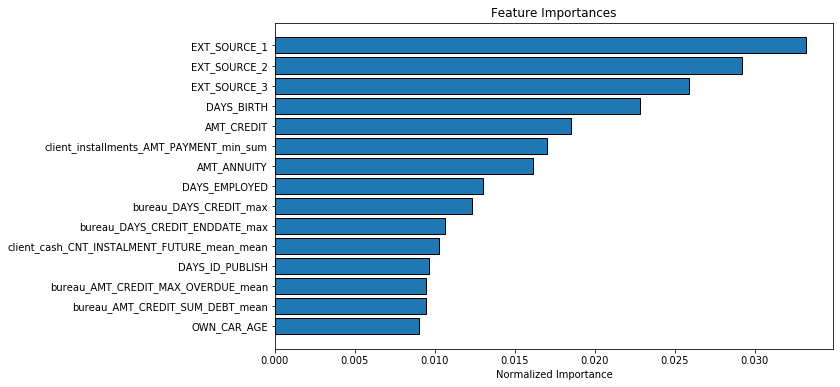

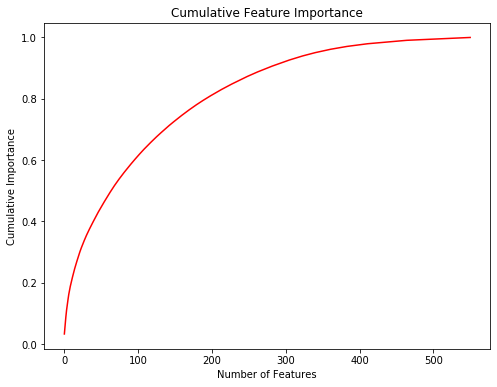

341 features required for 0.95 of cumulative importance


In [36]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

We can keep only the features needed for 95% importance

In [37]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]
test_small = test[features_to_keep]

In [38]:
train_small['TARGET'] = train_labels
train_small['SK_ID_CURR'] = train_ids
test_small['SK_ID_CURR'] = test_ids

train_small.to_csv('m_train_small.csv', index = False)
test_small.to_csv('m_test_small.csv', index = False)

### Test New Featuresets

The last step of feature removal we did seems like it may have the potential to hurt the model the most. Therefore we want to test the effect of this removal. To do that, we can use a standard model and change the features.

We will use a fairly standard LightGBM model, similar to the one we used for feature selection. The main difference is this model uses five-fold cross validation for training and we use it to make predictions. There's a lot of code here, but that's because I included documentation and a few extras (such as feature importances) that aren't strictly necessary. For now, understanding the entire model isn't critical, just know that we are using the same model with two different datasets to see which one performs the best.


In [39]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

## Test "Full" Dataset

This is the expanded dataset. To recap the process to make this dataset we:

    Removed collinear features as measured by the correlation coefficient greater than 0.9
    Removed any columns with greater than 80% missing values in the train or test set
    Removed all features with non-zero feature importances



In [40]:
train['TARGET'] = train_labels
train['SK_ID_CURR'] = train_ids
test['SK_ID_CURR'] = test_ids

submission, feature_importances, metrics = model(train, test)

Training Data Shape:  (307511, 551)
Testing Data Shape:  (48744, 551)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.829266	train's binary_logloss: 0.516103	valid's auc: 0.782566	valid's binary_logloss: 0.536298
[400]	train's auc: 0.86661	train's binary_logloss: 0.473347	valid's auc: 0.784336	valid's binary_logloss: 0.509446
Early stopping, best iteration is:
[351]	train's auc: 0.858508	train's binary_logloss: 0.4828	valid's auc: 0.784581	valid's binary_logloss: 0.515145
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.828968	train's binary_logloss: 0.516407	valid's auc: 0.784276	valid's binary_logloss: 0.537319
[400]	train's auc: 0.866475	train's binary_logloss: 0.474152	valid's auc: 0.786296	valid's binary_logloss: 0.510156
Early stopping, best iteration is:
[348]	train's auc: 0.857937	train's binary_logloss: 0.484065	valid's auc: 0.786637	valid's binary_logloss: 0.516309
Training until validation scores don't impr

In [41]:
metrics

,fold,train,valid
0,0,0.858508,0.784581
1,1,0.857937,0.786637
2,2,0.883256,0.779872
3,3,0.858714,0.784282
4,4,0.863145,0.786399
5,overall,0.864312,0.784234


In [42]:
#submission.to_csv('selected_features_submission.csv', index = False)

### Test "Small" Dataset

The small dataset requires one additional step over the ful l dataset:

    Keep only features needed to reach 95% cumulative importance in the gradient boosting machine



In [43]:
submission_small, feature_importances_small, metrics_small = model(train_small, test_small)

Training Data Shape:  (307511, 340)
Testing Data Shape:  (48744, 340)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.829446	train's binary_logloss: 0.516052	valid's auc: 0.78186	valid's binary_logloss: 0.536319
[400]	train's auc: 0.866675	train's binary_logloss: 0.47348	valid's auc: 0.783843	valid's binary_logloss: 0.509503
Early stopping, best iteration is:
[406]	train's auc: 0.867698	train's binary_logloss: 0.472277	valid's auc: 0.783911	valid's binary_logloss: 0.50882
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.828926	train's binary_logloss: 0.516811	valid's auc: 0.78465	valid's binary_logloss: 0.537878
Early stopping, best iteration is:
[289]	train's auc: 0.847104	train's binary_logloss: 0.496141	valid's auc: 0.785975	valid's binary_logloss: 0.524717
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.829749	train's binary_logloss: 0.515466	valid's auc: 0.77721	valid's binary_l

In [44]:
metrics_small

,fold,train,valid
0,0,0.867698,0.783911
1,1,0.847104,0.785975
2,2,0.859078,0.778863
3,3,0.862300,0.785234
4,4,0.858640,0.786148
5,overall,0.858964,0.784019


In [45]:
#submission_small.to_csv('selected_features_small_submission.csv', index = False)

## PCA Example

In [46]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline

In [47]:
# Make sure to drop the ids and target
train = train.drop(columns = ['SK_ID_CURR', 'TARGET'])
test = test.drop(columns = ['SK_ID_CURR'])

# Make a pipeline with imputation and pca
pipeline = Pipeline(steps = [('imputer', Imputer(strategy = 'median')),
             ('pca', PCA())])

# Fit and transform on the training data
train_pca = pipeline.fit_transform(train)

# transform the testing data
test_pca = pipeline.transform(test)

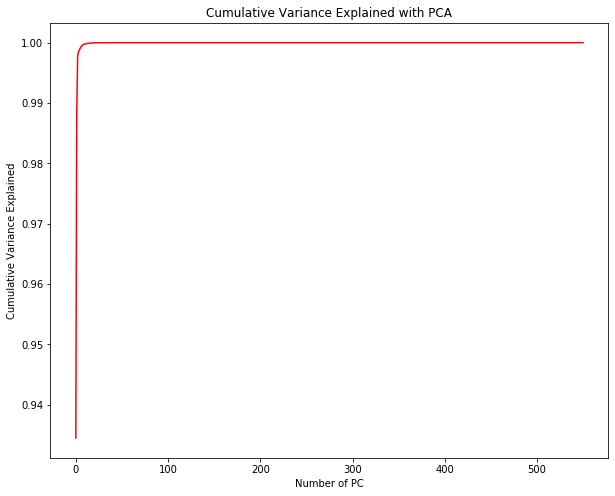

In [48]:
# Extract the pca object
pca = pipeline.named_steps['pca']

# Plot the cumulative variance explained

plt.figure(figsize = (10, 8))
plt.plot(list(range(train.shape[1])), np.cumsum(pca.explained_variance_ratio_), 'r-')
plt.xlabel('Number of PC'); plt.ylabel('Cumulative Variance Explained');
plt.title('Cumulative Variance Explained with PCA');



We only need a few prinicipal components to account for the majority of variance in the data. We can use the first two principal components to visualize the entire dataset. We will color the datapoints by the value of the target to see if using two principal components clearly separates the classes.

In [49]:
# Dataframe of pca results
pca_df = pd.DataFrame({'pc_1': train_pca[:, 0], 'pc_2': train_pca[:, 1], 'target': train_labels})


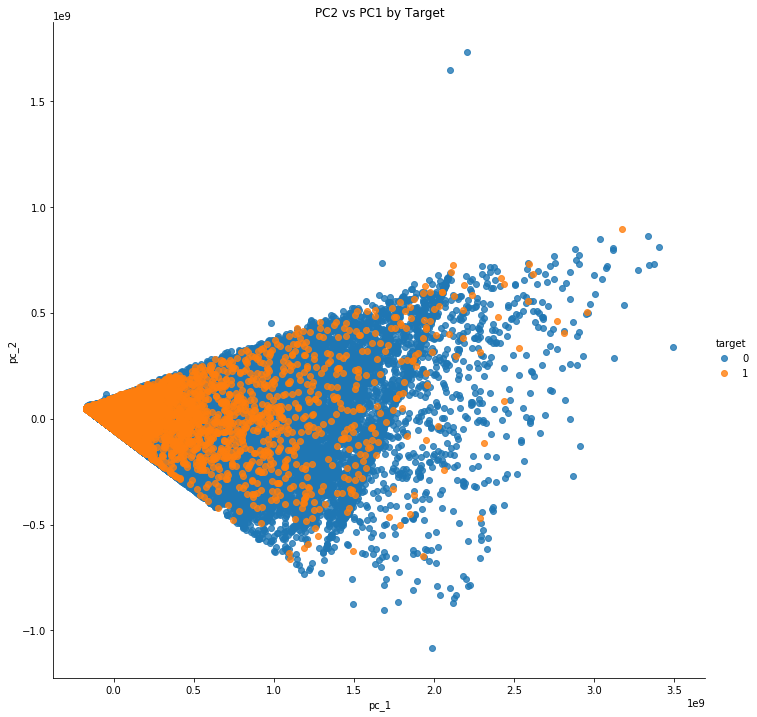

In [50]:
# Plot pc2 vs pc1 colored by target
sns.lmplot('pc_1', 'pc_2', data = pca_df, hue = 'target', fit_reg=False, size = 10)
plt.title('PC2 vs PC1 by Target');

In [51]:
print('2 principal components account for {:.4f}% of the variance.'.format(100 * np.sum(pca.explained_variance_ratio_[:2])))